## Import of Libraries

In [1]:
import pandas as pd
import numpy as np
from scipy.stats import pointbiserialr, chi2_contingency
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score,train_test_split,GridSearchCV
from sklearn.preprocessing import LabelEncoder,StandardScaler
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,r2_score, mean_squared_error
from xgboost import XGBClassifier,XGBRegressor
import copy
import lightgbm as lgb

## Reading the Data

Pandas function Usage example  
#### df = pd.read_csv(csv_file_path, sep=';', header=0, index_col='ID', usecols=['ID', 'Name', 'Age'])  
sep: Specifies the delimiter used in the CSV file. The default is a comma (,).  
header: Specifies which row to use as the column names. If set to None, the default column names will be used.  
index_col: Specifies which column to use as the row labels (index).  
usecols: Specifies which columns to read from the file.  


In [2]:
#Reading the csv file 
data1 = pd.read_csv("train.csv",index_col='id')
print("Data Statistics:",list(data1.columns.values))
# data1.head()
data_test = pd.read_csv("test.csv",index_col='id')

Data Statistics: ['brand', 'model', 'model_year', 'milage', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title', 'price']


In [3]:
data1.head()
print(data1.shape)
print(data1.dtypes)

data_x =  data1.drop('price', axis=1)
data_y = data1['price']

(188533, 12)
brand           object
model           object
model_year       int64
milage           int64
fuel_type       object
engine          object
transmission    object
ext_col         object
int_col         object
accident        object
clean_title     object
price            int64
dtype: object


In [12]:
def plot_categorical_counts(data, columns):
    """
    Plot counts of categorical columns.

    Parameters:
    data (pd.DataFrame): The dataset to visualize.
    columns (list): List of categorical columns to visualize.
    """
    for column in columns:
        plt.figure(figsize=(8, 4))
        sns.countplot(x=column, data=data, palette='viridis')
        plt.title(f"Count Plot for {column}")
        plt.xticks(rotation=45)
        plt.show()
              
def visualize_distributions(data, columns):
    """
    Visualize the distributions of numerical columns.

    Parameters:
    data (pd.DataFrame): The dataset to visualize.
    columns (list): List of numerical columns to visualize.
    """
    for column in columns:
        plt.figure(figsize=(8, 4))
        sns.histplot(data[column], kde=True, bins=30, color='blue')
        plt.title(f"Distribution of {column}")
        plt.xlabel(column)
        plt.ylabel("Frequency")
        plt.show()
        
def summary_statistics(data):
    """
    Compute and print summary statistics for numerical columns.

    Parameters:
    data (pd.DataFrame): The dataset to analyze.

    Returns:
    pd.DataFrame: Summary statistics.
    """
    summary = data.describe()
    print("\nSummary Statistics:")
    print(summary)
    return summary

def plot_multiple_boxplots(data):
    """
    Plot multiple boxplots for all numerical variables in the dataset.

    Parameters:
    data (pd.DataFrame): The dataset to visualize.
    """
    numerical_columns = data.select_dtypes(include=[np.number]).columns
    if numerical_columns.empty:
        print("No numerical columns found in the dataset.")
        return

    plt.figure(figsize=(15, 8))
    data_melted = data[numerical_columns].melt(var_name='Variable', value_name='Value')
    sns.boxplot(x='Variable', y='Value', data=data_melted, palette='Set3')
    plt.title("Boxplots for All Numerical Variables")
    plt.xticks(rotation=45)
    plt.show()


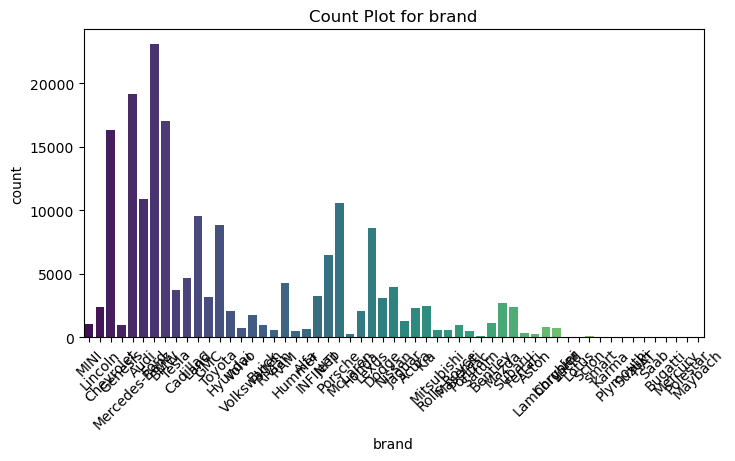

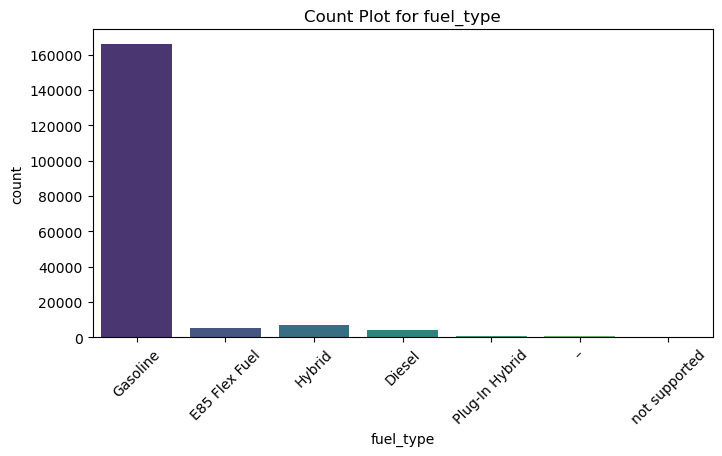

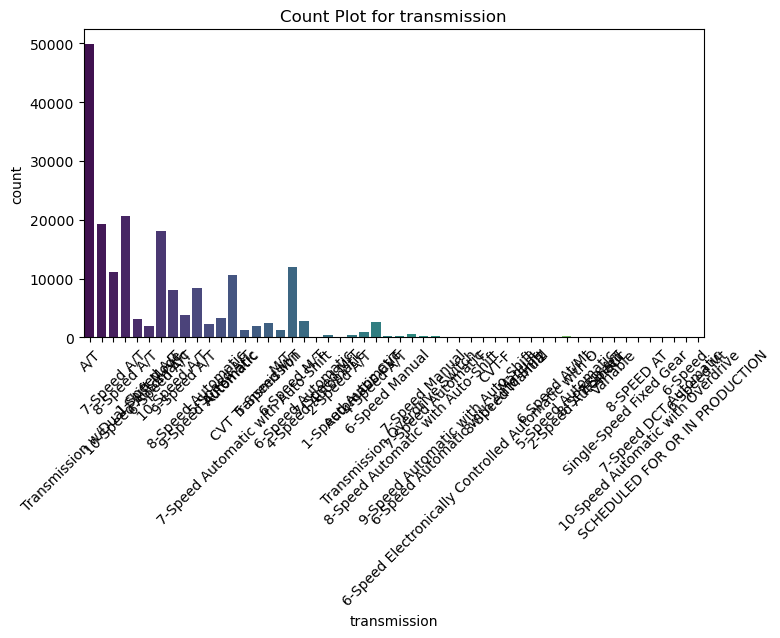

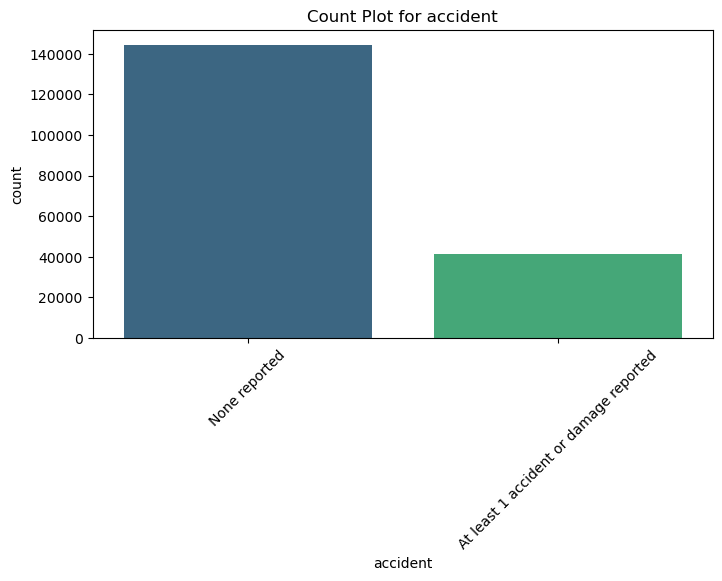

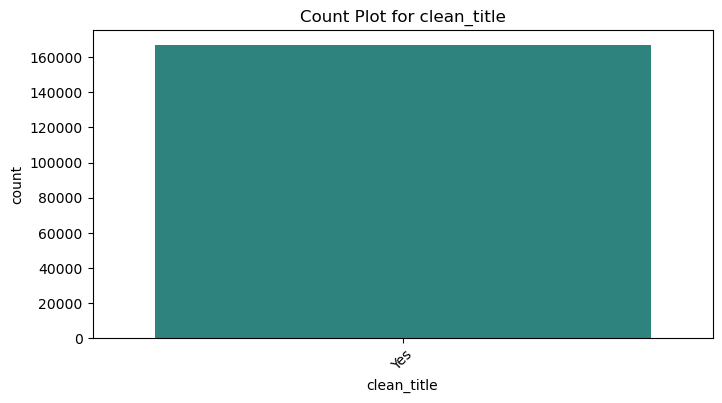

In [13]:
# Separate numerical and categorical columns
numerical_features = data1.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = data1.select_dtypes(exclude=[np.number]).columns.tolist()

features_to_plot = ['brand','fuel_type','transmission','accident','clean_title']
plot_categorical_counts(data1,features_to_plot)

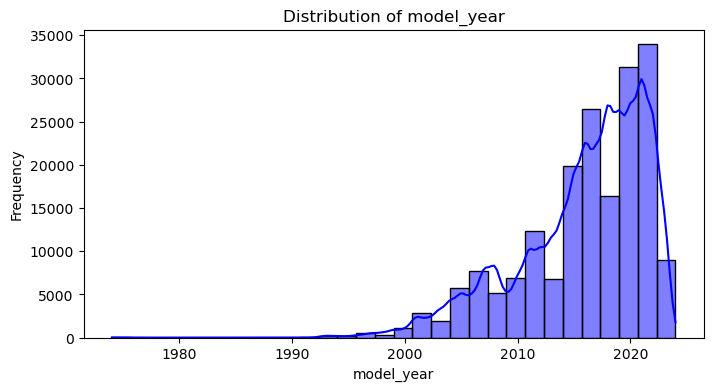

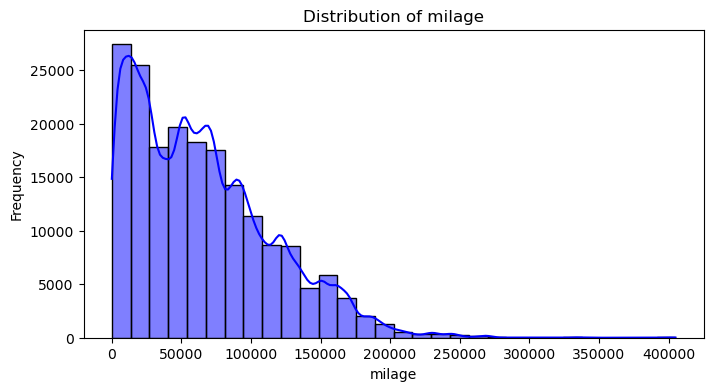

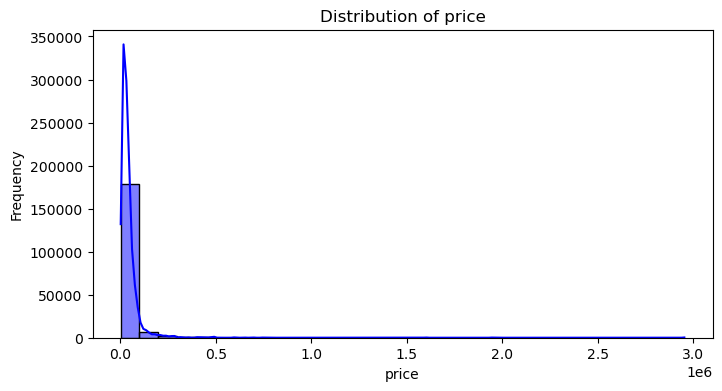

In [6]:
visualize_distributions(data1, numerical_features)

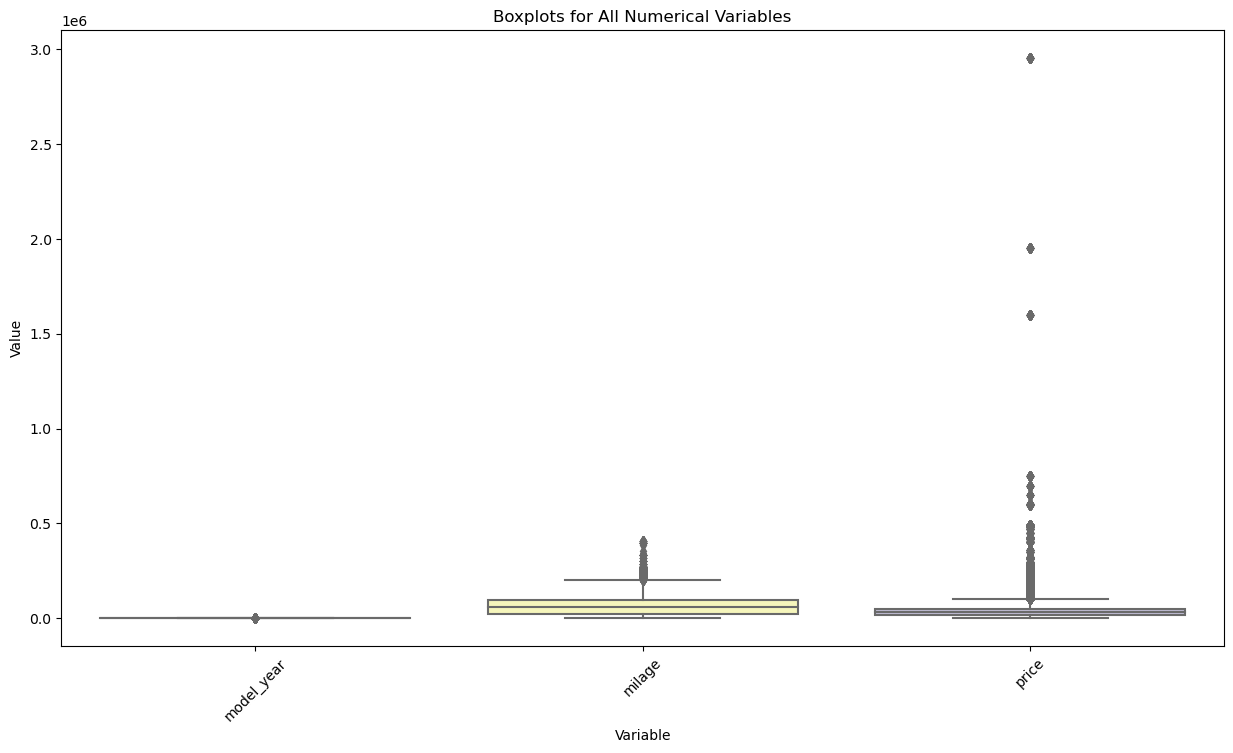

In [7]:
plot_multiple_boxplots(data1)

In [8]:
summary_statistics(data1)


Summary Statistics:
          model_year         milage         price
count  188533.000000  188533.000000  1.885330e+05
mean     2015.829998   65705.295174  4.387802e+04
std         5.660967   49798.158076  7.881952e+04
min      1974.000000     100.000000  2.000000e+03
25%      2013.000000   24115.000000  1.700000e+04
50%      2017.000000   57785.000000  3.082500e+04
75%      2020.000000   95400.000000  4.990000e+04
max      2024.000000  405000.000000  2.954083e+06


,model_year,milage,price
count,188533.000000,188533.000000,1.885330e+05
mean,2015.829998,65705.295174,4.387802e+04
std,5.660967,49798.158076,7.881952e+04
min,1974.000000,100.000000,2.000000e+03
25%,2013.000000,24115.000000,1.700000e+04
50%,2017.000000,57785.000000,3.082500e+04
75%,2020.000000,95400.000000,4.990000e+04
max,2024.000000,405000.000000,2.954083e+06


### Key methods to analyze feature-label relationships: 
 
#### Correlation Analysis: 
 
Pearson Correlation: Measures the linear relationship between two numerical features, providing a coefficient between -1 (strong negative correlation) and 1 (strong positive correlation). <br>
 
Spearman's Rank Correlation: Suitable for non-normally distributed data, analyzes the monotonic relationship between variables based on their ranks. 
 
#### Chi-Square Test: 
 
Used to assess the association between two categorical features, indicating whether there is a statistically significant relationship between the categories. 
 
#### Visualization Techniques: 
 
Scatterplots: Visually represent the relationship between two numerical variables, allowing you to identify patterns like linear trends, outliers, and clusters. <br>
 
Boxplots: Useful for comparing the distribution of a feature across different label categories. 

####  Machine Learning Feature Importance: 
 
Decision Trees: Provide feature importance scores based on how much each feature contributes to the decision-making process. 
 
Random Forests: Ensemble of decision trees, offering more robust feature importance estimations. 
 
 

In [19]:
# First we will calculated the correlation between each variable and the target variables


# Calculate Pearson correlation for numerical features
numerical_corr = data_x[numerical_features].corrwith(data_y)

# Function to calculate Point-biserial correlation for categorical features
def point_biserial_correlation(cat_col, target_col):
    # Convert categorical to numeric
    cat_encoded, _ = pd.factorize(cat_col)
    return pointbiserialr(cat_encoded, target_col)[0]

# Calculate Point-biserial correlation for categorical features with numerical target
categorical_corr = {col: point_biserial_correlation(data_x[col], data_y) for col in categorical_features}

print(categorical_corr)

['brand', 'model', 'fuel_type', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
{'brand': 0.017154313826276343, 'model': -0.006991731806850264, 'fuel_type': 0.0006570516224537436, 'engine': 0.008914287463639921, 'transmission': 0.034407136084980146, 'ext_col': 0.08533000327719834, 'int_col': 0.09194994221063321, 'accident': -0.1230337828036063, 'clean_title': -0.08943269629433122}


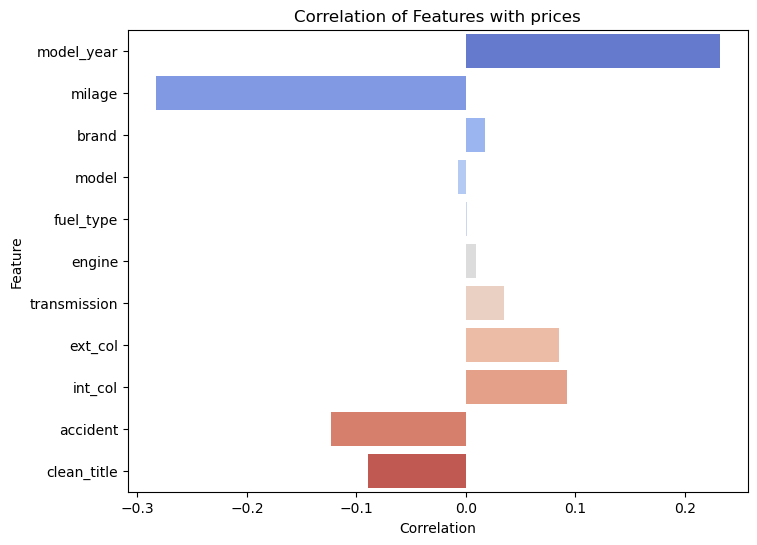

In [20]:
correlations = pd.concat([numerical_corr, pd.Series(categorical_corr)], axis=0)
# print(correlations)
correlations = correlations.rename('correlation').reset_index()
correlations.columns = ['Feature', 'Correlation']
# Visualization using Seaborn
plt.figure(figsize=(8, 6))
sns.barplot(data=correlations, x='Correlation', y='Feature', palette="coolwarm")
plt.title('Correlation of Features with prices')
plt.show()

## Removing the irrelevant features 

In [21]:
# # The variables from the correlation graph that seems to be irreleavant should be removed 
# # Hence dropping these columns
columns_to_drop = ['fuel_type']
data_xd = data_x.drop(columns=columns_to_drop,axis = 1)
# data_xd.head()

data_test_x = data_test.drop(columns=columns_to_drop,axis = 1)
# data_test_x.head()


## Filling the missing values
Here we will use the mean or mode method to fill the missing values.  
If the values are categorical then we use the mode.  
For the numerical values we use the median.  

In [22]:
# count_test = data_test.isna().sum()
# print(count)

# Using mean for the numerical column
columns_to_handle = numerical_features
data_xd[columns_to_handle] = data_xd[columns_to_handle].fillna(data_xd[columns_to_handle].mean())
data_test_x[columns_to_handle] = data_test_x[columns_to_handle].fillna(data_test_x[columns_to_handle].mean())

# Dataframe using mean of the columns 
# Using the mode for the categorical columns
categorical_features_d = copy.deepcopy(categorical_features)
categorical_features_d.remove('fuel_type')
columns_to_handle = categorical_features_d
print(columns_to_handle)

data_xd[columns_to_handle] = data_xd[columns_to_handle].fillna(data_xd[columns_to_handle].mode().iloc[0])
data_test_x[columns_to_handle] = data_test_x[columns_to_handle].fillna(data_test_x[columns_to_handle].mode().iloc[0])

# # To ensure that we do not have any Nan values in a dataframe
count = data_xd.isna().sum()
count_test = data_test_x.isna().sum()
print(count_test)



['brand', 'model', 'engine', 'transmission', 'ext_col', 'int_col', 'accident', 'clean_title']
brand           0
model           0
model_year      0
milage          0
engine          0
transmission    0
ext_col         0
int_col         0
accident        0
clean_title     0
dtype: int64


## Data splitting for training and validation

In [23]:
X_train, X_val, y_train, y_val = train_test_split(data_xd, data_y, test_size=0.2, random_state=42)

## Problem Statement 
we need to predict the prices of the used cars. Hence it is a Regression problem.
We will use the  Supervised learning Regression methods as below:  
1. Linear Regression
2. Random Forest
3. XGBoost
4. LGBM

### 1. Linear Regression
we will need to do the encoding for categorical variables 

In [24]:
## Decision trees do not require scaling hence we only applied the label encoder for teh categorical features 

label_encoder = LabelEncoder()

for col in categorical_features_d:
    X_train[col] = label_encoder.fit_transform(X_train[col])
    X_val[col] = label_encoder.fit_transform(X_val[col])
    data_xd[col] = label_encoder.fit_transform(data1[col])
    data_test_x[col] = label_encoder.fit_transform(data_test[col])

reg = LinearRegression()
reg.fit(X_train, y_train)

predictions = reg.predict(X_val)
# print(predictions)

rmse = mean_squared_error(y_val, predictions, squared=False)
print(" rmse value:",rmse)


# cm = metrics.confusion_matrix(label_df, predictions)
# print(cm)

 rmse value: 70306.64080710348


### 2. Random Forest Regressor

In [25]:
rf = RandomForestRegressor(n_estimators=400,random_state=42)
rf.fit(X_train, y_train)

predictions = rf.predict(X_val)

rmse = mean_squared_error(y_val, predictions, squared=False)
print(" rmse value:",rmse)

 rmse value: 73632.60427219565


### 3. XGB Regressor

In [26]:
xgb = XGBRegressor(n_estimators=100, learning_rate=0.05, max_depth=3, random_state=42)
xgb.fit(X_train, y_train)

predictions = xgb.predict(X_val)

rmse = mean_squared_error(y_val, predictions, squared=False)
print(" rmse value:",rmse)

 rmse value: 69050.39195068431


### 4. LGBM model

In [30]:
# Create the LGBM Regressor model
lgbm_model = lgb.LGBMRegressor(n_estimators=1000, learning_rate=0.01, max_depth=-1)
lgbm_model.fit(X_train, y_train)


predictions = lgbm_model.predict(X_val)

rmse = mean_squared_error(y_val, predictions, squared=False)
print(" rmse value:",rmse)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003012 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1247
[LightGBM] [Info] Number of data points in the train set: 150826, number of used features: 9
[LightGBM] [Info] Start training from score 43890.785316
 rmse value: 69030.9388036375


## Optimization

In [ ]:
xgb_reg = XGBRegressor(objective='reg:squarederror', random_state=42)

# Define the hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees
    'max_depth': [3, 5, 7],           # Maximum depth of a tree
    'learning_rate': [0.01, 0.1, 0.2], # Learning rate (eta)
    'subsample': [0.7, 0.8, 1],       # Subsample ratio of the training data
    'colsample_bytree': [0.7, 0.8, 1]  # Subsample ratio of features for each tree
}
# Set up GridSearchCV with 3-fold cross-validation
grid_search = GridSearchCV(estimator=xgb_reg, param_grid=param_grid, 
                           cv=3, scoring='neg_mean_squared_error', verbose=1)

# Fit GridSearchCV to the training data
grid_search.fit(X_train, y_train)

# Get the best parameters and score
print("Best hyperparameters:", grid_search.best_params_)
print("Best score (negative MSE):", grid_search.best_score_)
# Use the best model found by GridSearchCV
best_model = grid_search.best_estimator_

# Predict on the test set
y_pred = best_model.predict(X_val)

# Calculate Mean Squared Error (MSE)
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_val, y_pred,squared=False)
print("Test MSE:", mse)


## Final submission

In [31]:
# First we will train the best model on full data and then predict the testdata
lgbm_model.fit(data_xd, data_y)
# best_model = grid_search.best_estimator_
predictions = lgbm_model.predict(data_test_x)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1250
[LightGBM] [Info] Number of data points in the train set: 188533, number of used features: 10
[LightGBM] [Info] Start training from score 43878.016178


In [32]:
submission = pd.read_csv('sample_submission.csv')
submission["price"] =  predictions
submission.to_csv('my_submission.csv',index=False)